# Recommender Network for Movies
by Alexander Köhn

## Information for the tester
In the following my whole Software contribution is shown via a Jupyter notebook. My Final Report is included during the Notebook at the relevant parts of my code.
The summary of the tutorials are in an extra file in my repository.

## Credits
I got information for this project from the Tutorial (https://keras.io/examples/structured_data/collaborative_filtering_movielens/) and (https://www.tensorflow.org/recommenders/examples/basic_retrieval)

## Project Goal and underlying topic
The Project Goal is to implement a recommender system for love pairs, which want to watch a movie together during the winter holidays. The motivation is to reduce the time couples spend searching for the right movie.
Common Platforms use recommender systems with the data of the signed account. These Systems are not achieving the best results, if the account is most often used alone by one person and just used sometimes to watch movies together.
Implementing a recommender system with the input of two people, which want to watch a movie together, and a output of movies, which are good for both of them, is the Goal.

Additionally we want to have some more features.
1. We can decide which users interest is more important for the network.
2. We can decide if the network should recommend a movie they will likely watch (Retrieval) or they will likely like (Ranking)

## Inputs
First we need some Packages for building the network and analysing the data.

In [1]:
%pip install -q tensorflow-recommenders
%pip install -q --upgrade tensorflow-datasets
%pip install -q scann

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\users\koehn\pycharmprojects\pythonproject\venv\scripts\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\users\koehn\pycharmprojects\pythonproject\venv\scripts\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement scann (from versions: none)
ERROR: No matching distribution found for scann
You should consider upgrading via the 'c:\users\koehn\pycharmprojects\pythonproject\venv\scripts\python.exe -m pip install --upgrade pip' command.


In [2]:
import os
import pprint
import tempfile

from typing import Dict, Text

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

import pandas as pd
import matplotlib.pyplot as plt

## Data
We are using the Movielens 100K Dataset, which features a set with 100,000 ratings (1-5) from 943 users on 1682 movies. Tensorflow already provides a method to download the Dataset to the hard disk. After the first download the dataset from the disk will be used.

In [3]:
# Ratings data.
ratings = tfds.load("movielens/100k-ratings", split="train")
# Features of all the available movies.
movies = tfds.load("movielens/100k-movies", split="train")

As you can see, each rating consists of a movie with specific genres and a user with demographic information.

In [4]:
for x in ratings.take(1).as_numpy_iterator():
  pprint.pprint(x)

{'bucketized_user_age': 45.0,
 'movie_genres': array([7], dtype=int64),
 'movie_id': b'357',
 'movie_title': b"One Flew Over the Cuckoo's Nest (1975)",
 'raw_user_age': 46.0,
 'timestamp': 879024327,
 'user_gender': True,
 'user_id': b'138',
 'user_occupation_label': 4,
 'user_occupation_text': b'doctor',
 'user_rating': 4.0,
 'user_zip_code': b'53211'}


In [5]:
for x in movies.take(1).as_numpy_iterator():
  pprint.pprint(x)

{'movie_genres': array([4], dtype=int64),
 'movie_id': b'1681',
 'movie_title': b'You So Crazy (1994)'}


## Analaysis of the data
We can gain a better intuition for the dataset if we gather information about statistical information of the dataset.


## Prepocessing of the data


To simplify our model we will only use the user_id, movie_title and the user_rating from the Dataset.

In [6]:
ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
    "user_rating": x["user_rating"],
})
movies = movies.map(lambda x: x["movie_title"])

We are shuffling the data of the rating to randomize the learning and to avoid a bias in the train and test data.

In [7]:
tf.random.set_seed(37)
shuffled = ratings.shuffle(100_000, seed=37, reshuffle_each_iteration=True)

We are dividing the dataset in 80 % train data and 20% test data.

In [8]:
train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

Now we want to get two lists. The first list unique_movie_titles consists of all the movie titles, but every title is only saved once in the list. The second list unique_user_ids consists of all the users, in the same was as the first.

In [9]:
movie_titles = movies.batch(1_000)
user_ids = ratings.batch(1_000_000).map(lambda y: y["user_id"])

unique_movie_titles = np.unique(np.concatenate(list(movie_titles)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

print("First 10 Movie titles: ")
print(unique_movie_titles[:10])

print("\nThe total count of users: ", len(unique_user_ids))
print("The total count of movies: ", len(unique_movie_titles))

First 10 Movie titles: 
[b"'Til There Was You (1997)" b'1-900 (1994)' b'101 Dalmatians (1996)'
 b'12 Angry Men (1957)' b'187 (1997)' b'2 Days in the Valley (1996)'
 b'20,000 Leagues Under the Sea (1954)' b'2001: A Space Odyssey (1968)'
 b'3 Ninjas: High Noon At Mega Mountain (1998)' b'39 Steps, The (1935)']

The total count of users:  943
The total count of movies:  1664


## Architecture of our model
The Goal is to give the

In [10]:
class MovielensModel(tfrs.models.Model):

    def __init__(self):
        super().__init__()
        embedding_dimension = 32

        # Compute embeddings for users.
        self.user_embeddings = tf.keras.Sequential([
            tf.keras.layers.StringLookup(
                vocabulary=unique_user_ids, mask_token=None),
            tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
        ])

        # Compute embeddings for movies.
        self.movie_embeddings = tf.keras.Sequential([
            tf.keras.layers.StringLookup(
                vocabulary=unique_movie_titles, mask_token=None),
            tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
        ])

        # Compute predictions.
        self.ratings = tf.keras.Sequential([
            # Learn multiple dense layers.
            tf.keras.layers.Dense(256, activation="relu"),
            tf.keras.layers.Dense(64, activation="relu"),
            # Make rating predictions in the final layer.
            tf.keras.layers.Dense(1)
        ])

        self.task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.RootMeanSquaredError()]
        )

    def call(self, features: Dict[str, tf.Tensor]) -> tf.Tensor:
        user_id = features["user_id"]
        movie_title = features["movie_title"]

        user_embedding = self.user_embeddings(user_id)
        movie_embedding = self.movie_embeddings(movie_title)

        return self.ratings(tf.concat([user_embedding, movie_embedding], axis=1))

    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
        labels = features.pop("user_rating")

        rating_predictions = self(features)

        # The task computes the loss and the metrics.
        return self.task(labels=labels, predictions=rating_predictions)

    def couple_movie_recommendation(self, user_id_1, user_id_2, movie_list):
        test_ratings_1 = {}
        test_ratings_2 = {}
        test_ratings_combined = {}
        for movie_title in movie_list:
            test_ratings_1[movie_title] = self({
                "user_id": user_id_1,
                "movie_title": np.array([movie_title])
            })
            test_ratings_2[movie_title] = self({
                "user_id": user_id_2,
                "movie_title": np.array([movie_title])
            })
            test_ratings_combined[movie_title] = (test_ratings_1[movie_title] + test_ratings_2[movie_title]) / 2

        test_ratings_combined = sorted(test_ratings_combined.items(), key=lambda x: x[1], reverse=True)
        print("Recommendation for the two users: \n")
        for title, score in test_ratings_combined[:10]:
            print(f"{title}: {score}")



## Building our model

In [11]:
model = MovielensModel()
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

In [12]:
cached_train = train.shuffle(100_000).batch(65536).cache()
cached_test = test.batch(16384).cache()

Epoch 1/50
2/2 [==============================] - 3s 803ms/step - root_mean_squared_error: 3.5475 - loss: 9.6453 - regularization_loss: 0.0000e+00 - total_loss: 9.6453 - val_root_mean_squared_error: 1.7336 - val_loss: 3.0293 - val_regularization_loss: 0.0000e+00 - val_total_loss: 3.0293
Epoch 2/50
2/2 [==============================] - 0s 47ms/step - root_mean_squared_error: 1.9529 - loss: 6.0459 - regularization_loss: 0.0000e+00 - total_loss: 6.0459 - val_root_mean_squared_error: 1.5010 - val_loss: 2.2243 - val_regularization_loss: 0.0000e+00 - val_total_loss: 2.2243
Epoch 3/50
2/2 [==============================] - 0s 47ms/step - root_mean_squared_error: 1.4804 - loss: 2.0479 - regularization_loss: 0.0000e+00 - total_loss: 2.0479 - val_root_mean_squared_error: 1.6932 - val_loss: 2.8317 - val_regularization_loss: 0.0000e+00 - val_total_loss: 2.8317
Epoch 4/50
2/2 [==============================] - 0s 47ms/step - root_mean_squared_error: 1.6111 - loss: 1.8834 - regularization_loss: 0.0

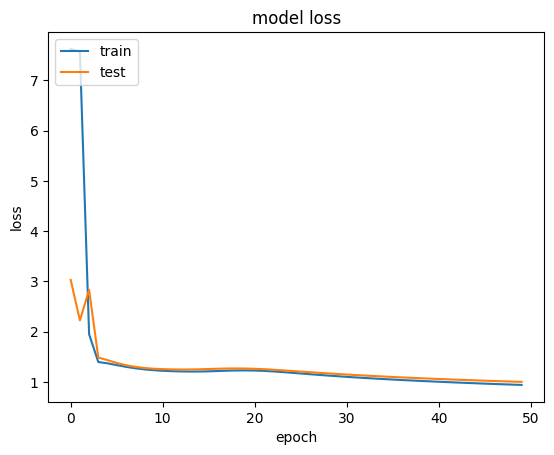

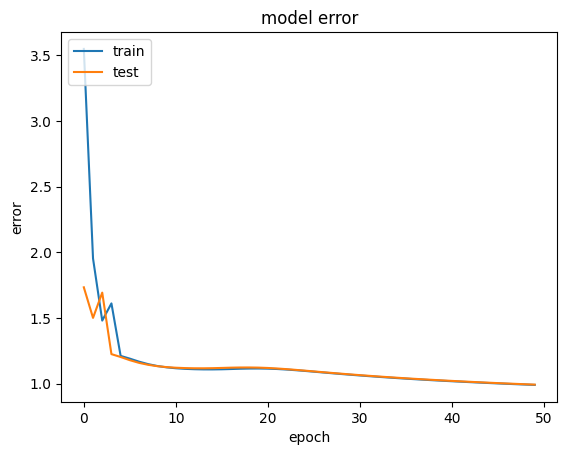

In [13]:
history = model.fit(cached_train, epochs=50, validation_data=cached_test)

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

plt.plot(history.history["root_mean_squared_error"])
plt.plot(history.history["val_root_mean_squared_error"])
plt.title("model error")
plt.ylabel("error")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [14]:
metrics = model.evaluate(cached_test, return_dict=True)

print(f"Retrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}.")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}.")

2/2 [==============================] - 0s 16ms/step - root_mean_squared_error: 0.9932 - loss: 0.9945 - regularization_loss: 0.0000e+00 - total_loss: 0.9945


KeyError: 'factorized_top_k/top_100_categorical_accuracy'

## Evaluating our model

In [15]:
user_1 = np.array(["42"])
user_2 = np.array(["72"])
test_movie_titles, ind = np.unique(np.concatenate(list(movie_titles)), return_index=True)
test = test_movie_titles[np.argsort(ind)]

model.couple_movie_recommendation(user_1, user_2, test[:100])

Recommendation for the two users: 

b'Pulp Fiction (1994)': [[4.4664464]]
b'Apocalypse Now (1979)': [[4.264622]]
b'African Queen, The (1951)': [[4.1641574]]
b'Die Hard (1988)': [[4.1250105]]
b'Stand by Me (1986)': [[4.1234226]]
b'Raise the Red Lantern (1991)': [[4.093865]]
b'Jurassic Park (1993)': [[4.078675]]
b'Mr. Smith Goes to Washington (1939)': [[4.0478554]]
b'Killing Fields, The (1984)': [[4.0278153]]
b'Wings of Desire (1987)': [[4.0021234]]
